# Setup - GPU Solver Examples

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [7]:
import sys, sys
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np
from jfi import jaxm

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
import pmpc
import pmpc.experimental

### Define dynamics

In [8]:
def car(x, u, p):
    """
    unicycle car dynamics, 4 states, 2 actions
    x1: position x
    x2: position y
    x3: speed (local frame)
    x4: orientation angle

    u1: acceleration
    u2: turning speed (independent of velocity)
    """
    assert x.shape[-1] == 4 and u.shape[-1] == 2
    v_scale, w_scale, T = p[..., 0], p[..., 1], p[..., 2]
    eps = 1e-3
    u1, u2 = v_scale * u[..., 0], w_scale * -u[..., 1]
    u1 = u1 + jaxm.where(u1 >= 0.0, eps, -eps)
    u2 = u2 + jaxm.where(u2 >= 0.0, eps, -eps)

    x0, y0, v0, th0 = x[..., 0], x[..., 1], x[..., 2], x[..., 3]
    xp1 = (
        x0
        + (
            u2 * jaxm.sin(T * u2 + th0) * v0
            + T * u1 * u2 * jaxm.sin(T * u2 + th0)
            + u1 * jaxm.cos(T * u2 + th0)
        )
        / u2**2
        - (jaxm.sin(th0) * u2 * v0 + jaxm.cos(th0) * u1) / u2**2
    )
    xp2 = (
        y0
        - (
            u2 * jaxm.cos(T * u2 + th0) * v0
            - u1 * jaxm.sin(T * u2 + th0)
            + T * u1 * u2 * jaxm.cos(T * u2 + th0)
        )
        / u2**2
        + (jaxm.cos(th0) * u2 * v0 - jaxm.sin(th0) * u1) / u2**2
    )
    xp3 = v0 + T * u1
    xp4 = T * u2 + th0
    xp = jaxm.stack([xp1, xp2, xp3, xp4], -1)
    return xp


def fx_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jaxm.moveaxis(jaxm.jacobian(lambda x: jaxm.sum(car(x, u, p), sum_dims))(x), 0, -2)


def fu_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jaxm.moveaxis(jaxm.jacobian(lambda u: jaxm.sum(car(x, u, p), sum_dims))(u), 0, -2)


@jaxm.jit
def f_fx_fu_fn(x, u):
    p = jaxm.to(jaxm.array([1.0, 1.0, 0.3]), dtype=x.dtype)
    return car(x, u, p), fx_(x, u, p), fu_(x, u, p)
    
SMOOTH_ALPHA = 1e2 # smooth constraints refinement parameter, higher is closer to hard constraints


---
# Specify the problem

In [12]:
N, xdim, udim = 20, 4, 2

Q = np.tile(np.eye(xdim), (N, 1, 1))
R = np.tile(1e-2 * np.eye(udim), (N, 1, 1))
x0 = np.tile(np.ones(xdim), (1,))
X_ref, U_ref = np.zeros((N, xdim)), np.zeros((N, udim))
X_prev, U_prev = np.zeros((N, xdim)), np.zeros((N, udim))
u_lim = 1.0
u_l, u_u = -u_lim * np.ones((N, udim)), u_lim * np.ones((N, udim))

opts = dict(verbose=True, u_l=u_l, u_u=u_u, reg_x=3e0, reg_u=1e0, max_it=50)
# WE ARE USING GPU HERE ############################################################################
opts["device"] = "cuda"
opts["solver_settings"] = dict(smooth_alpha=SMOOTH_ALPHA)  # GPU supports only smooth constraints
# WE ARE USING GPU HERE ############################################################################
problem = dict(f_fx_fu_fn=f_fx_fu_fn, Q=Q, R=R, x0=x0)
problem = dict(problem, X_ref=X_ref, U_ref=U_ref, X_prev=X_prev, U_prev=U_prev, u_l=u_l, u_u=u_u)
problem = dict(problem, **opts)

---
# Define the custom linear cost function

In [19]:
def lin_cost_fn(X, U, *args, **kw):
    cx = -5.0 * np.ones(X.shape)
    cu = None
    return cx, cu
problem["lin_cost_fn"] = lin_cost_fn

In [20]:
# let's solve the problem
X, U, data = pmpc.experimental.solve(**problem)

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
| 0001 |  1.507e-01 |  4.013e+01 |  2.921e+00 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0002 |  1.812e-01 |  2.671e+01 |  2.715e+00 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0003 |  2.111e-01 |  2.387e+01 |  2.025e+00 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0004 |  2.471e-01 |  1.975e+01 |  1.961e+00 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0005 |  2.813e-01 |  1.852e+01 |  1.149e+00 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0006 |  3.112e-01 |  1.675e+01 |  1.145e+00 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0007 |  3.404e-01 |  1.677e+01 |  1.221e+00 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0008 |  3.681e-01 |  1.565e+01 |  7.762e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0009 |  3.962e-01 |  1.510e+01 |  7.345e-01 |  3.0e+00 |  1.0e+00 |  1.0e+02 |
| 0010 |  4.227e-01 |  1.455

### Visualize the results

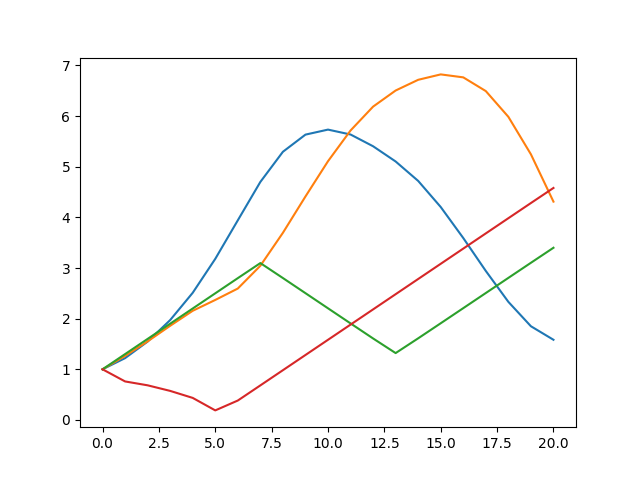

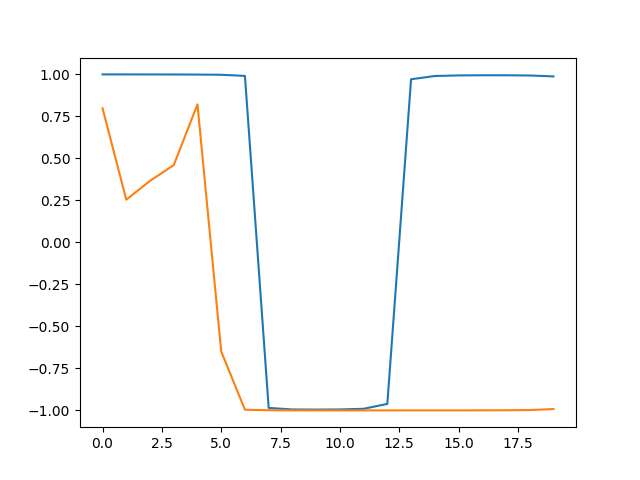

In [21]:
idx = 2
plt.figure(4356675)
plt.clf()
for r in range(X.shape[-1]):
    plt.plot(X[:, r], label=f"x{r}")
plt.show()
plt.figure(4534534)
plt.clf()
for r in range(U.shape[-1]):
    plt.plot(U[:, r], label=f"u{r}")
plt.show()

---
# Define custom differentiable cost (must be implemented in jax)

In [38]:
print(problem["lin_cost_fn"])  # we can use both linear and differentiable cost functions together


def diff_cost_fn(X, U, *args, **kw):
    print("custom cost queried (only ones for jit trace path)")
    X_ref = -5.0 * jaxm.ones(X.shape)
    U_ref = 1.0 * jaxm.ones(U.shape)
    return jaxm.mean((X - X_ref) ** 2) + jaxm.mean((U - U_ref) ** 2)

problem["diff_cost_fn"] = diff_cost_fn
problem["reg_x"] = 1e1


<function lin_cost_fn at 0x7f955c281ee0>


In [39]:
# let's solve the problem
X, U, data = pmpc.experimental.solve(**problem)

+------+------------+------------+------------+----------+----------+----------+
|  it  |   elaps    |    obj     |   resid    |  reg_x   |  reg_u   |  alpha   |
+------+------------+------------+------------+----------+----------+----------+
custom cost queried (only ones for jit trace path)
| 0001 |  2.179e+00 |  8.287e+01 |  1.864e+00 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0002 |  2.214e+00 |  7.238e+01 |  4.551e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0003 |  2.247e+00 |  7.156e+01 |  4.341e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0004 |  2.280e+00 |  7.103e+01 |  5.412e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0005 |  2.313e+00 |  7.050e+01 |  2.901e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0006 |  2.344e+00 |  7.014e+01 |  4.295e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0007 |  2.375e+00 |  6.993e+01 |  2.354e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0008 |  2.406e+00 |  6.975e+01 |  1.870e-01 |  1.0e+01 |  1.0e+00 |  1.0e+02 |
| 0009 |  2.438e+00 |  6.958e+01 |  2.254e-01 |  1.0e+01 |

### Visualize the results

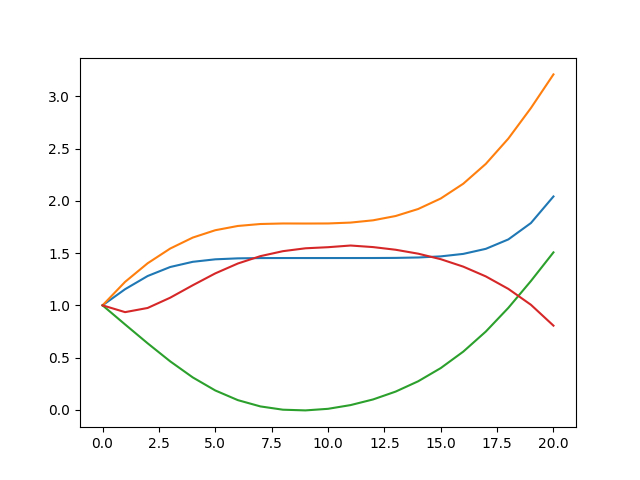

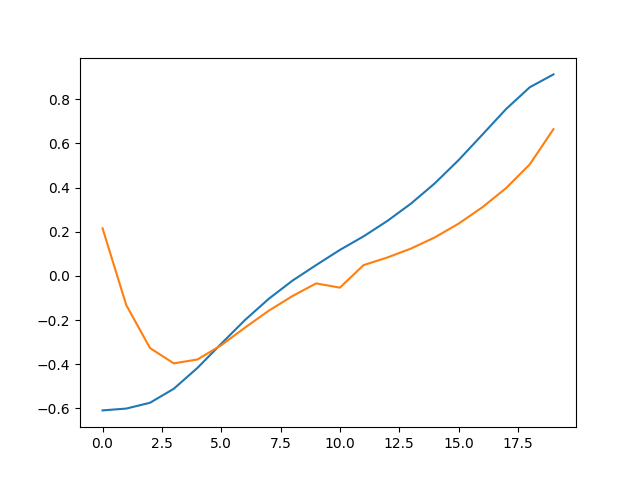

In [40]:
idx = 2
plt.figure(4356675)
plt.clf()
for r in range(X.shape[-1]):
    plt.plot(X[:, r], label=f"x{r}")
plt.show()
plt.figure(4534534)
plt.clf()
for r in range(U.shape[-1]):
    plt.plot(U[:, r], label=f"u{r}")
plt.show()